In [2]:
import pandas as pd
import numpy as np

# Loading dataset (features only)
df = pd.read_csv(r"C:\Users\rujha\OneDrive\Desktop\teg_project\TEG_data.csv")

# 1. Seebeck Voltage (V = S * ΔT)
df['Voltage_V'] = df['Seebeck_V_per_K'] * df['Delta_T_C']

# 2. Power (P = V^2 / R)
df['Power_W'] = (df['Voltage_V'] ** 2) / df['Rload_ohm']

# 3. Qin (heat input) - proportional to ΔT
df['Qin'] = df['Delta_T_C'] * 0.1   # scaling factor

# 4. Efficiency (%) = (Power / Qin) * 100
df['Efficiency_%'] = (df['Power_W'] / df['Qin']) * 100

# Drop helper column, since we don't want Qin in final output
df = df.drop(columns=['Qin'])

# Save
df.to_csv("TEG_with_targets.csv", index=False)

print(df.head(10))


   Delta_T_C  Rload_ohm      Material  Seebeck_V_per_K  Voltage_V   Power_W  \
0     238.30      19.64  Skutterudite          0.00020   0.047660  0.000116   
1     265.62      15.27  Skutterudite          0.00020   0.053124  0.000185   
2      51.11      11.04  Skutterudite          0.00020   0.010222  0.000009   
3     233.68       5.31  Skutterudite          0.00020   0.046736  0.000411   
4     170.75       3.08          PbTe          0.00018   0.030735  0.000307   
5     123.14       9.57        Bi2Te3          0.00022   0.027091  0.000077   
6      59.40       3.66          PbTe          0.00018   0.010692  0.000031   
7     248.65      17.67  Skutterudite          0.00020   0.049730  0.000140   
8      81.80       3.08        Bi2Te3          0.00022   0.017996  0.000105   
9     179.65      13.61        Bi2Te3          0.00022   0.039523  0.000115   

   Efficiency_%  
0      0.000485  
1      0.000696  
2      0.000185  
3      0.001760  
4      0.001796  
5      0.000623  
6   

In [3]:
# ++++++++++++ Scaling data ++++++++++++++++ 

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Loading dataset
df=pd.read_csv(r"C:\Users\rujha\OneDrive\Desktop\teg_project\TEG_with_targets.csv")

# Saving original 
df_original= df.copy()

# Scaling features
feature_cols=['Delta_T_C', 'Rload_ohm', 'Seebeck_V_per_K']
scaler_features= MinMaxScaler(feature_range=(0,1))
df_scaled_features= pd.DataFrame(
    scaler_features.fit_transform(df[feature_cols]),
    columns=[col+'_scaled' for col in feature_cols]
)

# scaling targets
target_cols=['Power_W', 'Efficiency_%']
scaler_targets=MinMaxScaler(feature_range=(0,1))
df_scaled_targets=pd.DataFrame(
    scaler_targets.fit_transform(df[target_cols]),
    columns=[col+'_scaled' for col in target_cols]
)

# combining both
df_ml= pd.concat([df_scaled_features, df_scaled_targets], axis=1) #stacks horizontally 

df_ml.to_csv("TEG_ml.csv", index=False)
print(df_ml.head(10))


   Delta_T_C_scaled  Rload_ohm_scaled  Seebeck_V_per_K_scaled  Power_W_scaled  \
0          0.753301          0.981053                     0.5        0.028949   
1          0.862625          0.751053                     0.5        0.046900   
2          0.004242          0.528421                     0.5        0.001387   
3          0.734814          0.226842                     0.5        0.105697   
4          0.482993          0.109474                     0.0        0.078536   
5          0.292477          0.451053                     1.0        0.018835   
6          0.037415          0.140000                     0.0        0.007037   
7          0.794718          0.877368                     0.5        0.035257   
8          0.127051          0.109474                     1.0        0.026222   
9          0.518607          0.663684                     1.0        0.028720   

   Efficiency_%_scaled  
0             0.030998  
1             0.047182  
2             0.007917  
3       

In [4]:
# +++++++++++ splitting the dataset ++++++++++++++++

from sklearn.model_selection import train_test_split
X=df_ml[['Delta_T_C_scaled', 'Rload_ohm_scaled', 'Seebeck_V_per_K_scaled']]
y=df_ml[['Power_W_scaled', 'Efficiency_%_scaled']]

X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# +++++++++++++ model training ++++++++++++++

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ++++ Linear Regression ++++++
lr_model= LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr= lr_model.predict(X_test)

print("Linear Regression:")
print("R2 score:", r2_score(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))

# Linear Regression is underfit because the relationship between del_t, Rload, Seebeck and power/Efficiency is non-linear

Linear Regression:
R2 score: 0.5190721578900493
MSE: 0.0045420761245971684


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# +++++++ Random Forest +++++++++++
rf_model= RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf= rf_model.predict(X_test)


print("Random Forest:")
print("R2 score:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest:
R2 score: 0.991942177454455
MSE: 7.514958087973152e-05


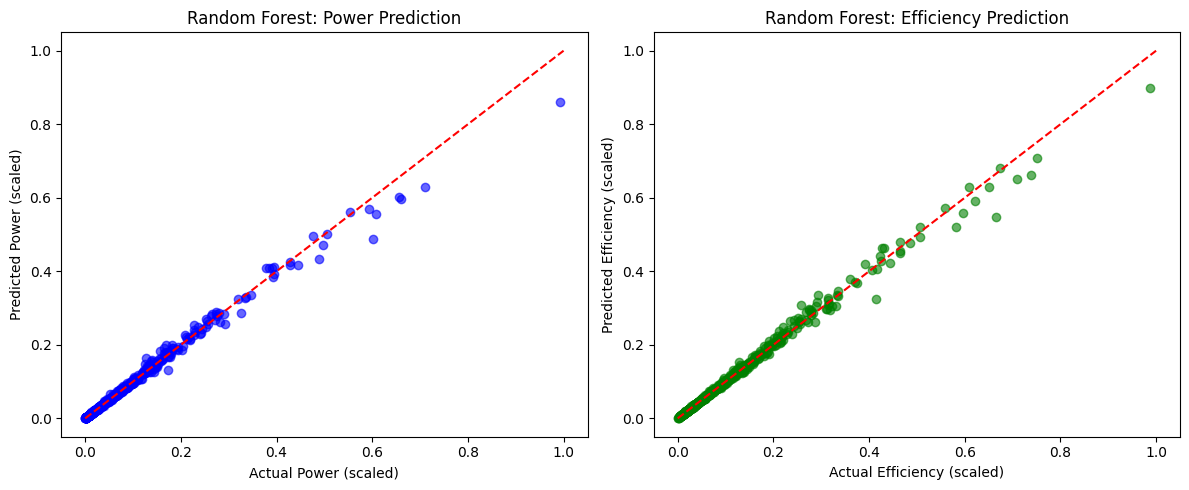

C:\Users\rujha\AppData\Local\Temp\ipykernel_15028\4118874512.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


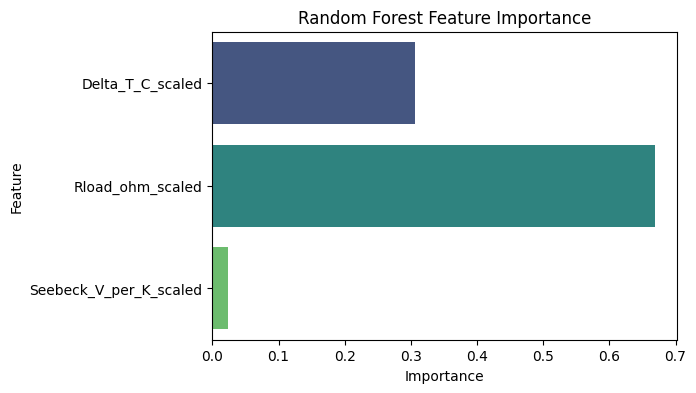

In [7]:
# +++++++++++++ Visualisation ++++++++++++++++++

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Power plot
axes[0].scatter(y_test['Power_W_scaled'], y_pred_rf[:,0], alpha=0.6, color='blue')
axes[0].plot([0,1],[0,1], 'r--')  # ideal line
axes[0].set_xlabel("Actual Power (scaled)")
axes[0].set_ylabel("Predicted Power (scaled)")
axes[0].set_title("Random Forest: Power Prediction")

# Efficiency plot
axes[1].scatter(y_test['Efficiency_%_scaled'], y_pred_rf[:,1], alpha=0.6, color='green')
axes[1].plot([0,1],[0,1], 'r--')  # ideal line
axes[1].set_xlabel("Actual Efficiency (scaled)")
axes[1].set_ylabel("Predicted Efficiency (scaled)")
axes[1].set_title("Random Forest: Efficiency Prediction")

plt.tight_layout()
plt.show()

# 2. Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
importances= rf_model.feature_importances_ #get important values

feature_importance= pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importance= feature_importance.sort_values(by= 'Importance', ascending=False)
print(feature_importance)


                  Feature  Importance
1        Rload_ohm_scaled    0.669343
0        Delta_T_C_scaled    0.306397
2  Seebeck_V_per_K_scaled    0.024260


++++++++++ Conclusion +++++++++++
1) Rload has the strongest influence on the model's predictions, since output power depends on the load.
2) Temprature difference is second most important.
3) Seebeck coefficient has a very low value since the seebeck coefficient in the dataset doesn't vary much.
